In [1]:
import torch

from model import Model
from config import config
from PIL import Image
from matplotlib import pyplot as plt
from torchvision import transforms
import numpy as np
from rich import print

from typing import Tuple, List

In [2]:
CHECKPOINT_PATH = './runs/model_amber-gorge-9_048_953.pth'
IMAGE_PATH = './example/image.jpg'

In [3]:
model = Model()

model.load_state_dict(torch.load(CHECKPOINT_PATH))

model.to(torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))

model.eval()

Model(
  (model): ByobNet(
    (stem): ConvNormAct(
      (conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNormAct2d(
        64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): SiLU(inplace=True)
      )
    )
    (stages): Sequential(
      (0): Sequential(
        (0): BottleneckBlock(
          (conv1_1x1): ConvNormAct(
            (conv): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn): BatchNormAct2d(
              128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): SiLU(inplace=True)
            )
          )
          (conv2_kxk): ConvNormAct(
            (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=128, bias=False)
            (bn): BatchNormAct2d(
              128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
  

In [4]:
def size_to_embedding(size: int) -> int:
    if size == 16:
        return 0
    elif size == 32:
        return 1
    elif size == 64:
        return 2
    elif size == 128:
        return 3
    elif size == 256:
        return 4
    elif size == 512:
        return 5
    elif size == 1024:
        return 6

In [5]:
class CroppedImage:
    def __init__(self, image: torch.Tensor, position: Tuple[int, int], size: Tuple[int, int], small_enough: bool = False):
        self.image = image
        self.position = position
        self.size = size
        self.small_enough = False

    def __str__(self):
        return f'CroppedImage(position={self.position}, size={self.size}, small_enough={self.small_enough})'
    
    def __repr__(self):
        return str(self)
    
    def clone(self):
        return CroppedImage(self.image.clone(), self.position, self.size, self.small_enough)

In [6]:
crop_transform = transforms.Compose([
    # transforms.Resize((256, 256)),
])


def crop_image(src: CroppedImage, size: Tuple[int, int] = (256, 256)) -> Tuple[List[CroppedImage], Tuple[int, int]]:
    image = src.image
    # print(image.shape)
    h, w = image.shape[-2:]
    th, tw = size

    if h % th != 0:
        h = h + th - h % th

    if w % tw != 0:
        w = w + tw - w % tw

    image = torch.nn.functional.pad(image, (0, w - image.shape[-1], 0, h - image.shape[-2]), value=-1)

    # print(image.shape, w, h)

    i = 0
    j = 0
    cropped_images = []
    while i + th <= h:
        while j + tw <= w:
            # print(i, j, i+th, j+tw)
            cropped_images.append(CroppedImage(
                crop_transform(image[..., i:i+th, j:j+tw]),
                (i + src.position[0], j + src.position[1]), (th, tw)
            ))
            j += tw
        j = 0
        i += th
    return cropped_images, (w // tw, h // th)

In [7]:
@torch.no_grad()
def predict(image: torch.Tensor, current_size: int) -> torch.Tensor:
    result: torch.Tensor = model(image.unsqueeze(0) + size_to_embedding(current_size))
    result = result.argmax(dim=1).cpu().tolist()[0]
    return result == 1

In [8]:
transform = config.transform()
inverse_transform = config.inverse_transform()

img = Image.open(IMAGE_PATH)

img = transform(img).cuda()

print(img.shape)

torch.Size([3, 768, 1024])

In [9]:
halt = 10

def recursion_predict(image: CroppedImage, current_size: int) -> List[CroppedImage]:
    global halt
    halt -= 1
    if halt == 0:
        return []
    
    if current_size == 16:
        return [CroppedImage(image.image.clone(), (0, 0), (16, 16), small_enough=True)]

    cropped_images, _ = crop_image(image, (current_size, current_size))

    # print(current_size, len(cropped_images))


    # plt.imshow(inverse_transform(image.image.clone()).permute(1, 2, 0).cpu())
    # plt.show()

    new_images = []
    remove_index = []

    for i, cropped_image in enumerate(cropped_images):
        cropped_image.small_enough = predict(cropped_image.image.clone(), current_size)

        if not cropped_image.small_enough:
            new_images.extend(recursion_predict(cropped_image.clone(), current_size // 2))
            remove_index.append(i)

    remove_index.sort(reverse=True)

    for i in remove_index:
        cropped_images.pop(i)

    cropped_images.extend(new_images)
            
    return cropped_images

In [10]:
img = CroppedImage(img, (0, 0), (1024, 1024))

cropped_images = recursion_predict(img, 512)

print(cropped_images)

[
    CroppedImage(position=(512, 0), size=(512, 512), small_enough=True),
    CroppedImage(position=(512, 512), size=(512, 512), small_enough=True),
    CroppedImage(position=(256, 0), size=(256, 256), small_enough=True),
    CroppedImage(position=(256, 256), size=(256, 256), small_enough=True),
    CroppedImage(position=(128, 0), size=(128, 128), small_enough=True),
    CroppedImage(position=(128, 128), size=(128, 128), small_enough=True),
    CroppedImage(position=(0, 0), size=(64, 64), small_enough=True),
    CroppedImage(position=(0, 64), size=(64, 64), small_enough=True),
    CroppedImage(position=(64, 0), size=(64, 64), small_enough=True),
    CroppedImage(position=(64, 64), size=(64, 64), small_enough=True),
    CroppedImage(position=(0, 128), size=(64, 64), small_enough=True),
    CroppedImage(position=(0, 192), size=(64, 64), small_enough=True),
    CroppedImage(position=(64, 128), size=(64, 64), small_enough=True),
    CroppedImage(position=(64, 192), size=(64, 64), small_enough=True),
    CroppedImage(position=(0, 256), size=(64, 64), small_enough=True),
    CroppedImage(position=(0, 320), size=(64, 64), small_enough=True),
    CroppedImage(position=(64, 256), size=(64, 64), small_enough=True),
    CroppedImage(position=(64, 320), size=(64, 64), small_enough=True),
    CroppedImage(position=(0, 384), size=(64, 64), small_enough=True),
    CroppedImage(position=(0, 448), size=(64, 64), small_enough=True),
    CroppedImage(position=(64, 384), size=(64, 64), small_enough=True),
    CroppedImage(position=(64, 448), size=(64, 64), small_enough=True),
    CroppedImage(position=(128, 256), size=(64, 64), small_enough=True),
    CroppedImage(position=(128, 320), size=(64, 64), small_enough=True),
    CroppedImage(position=(192, 256), size=(64, 64), small_enough=True),
    CroppedImage(position=(192, 320), size=(64, 64), small_enough=True),
    CroppedImage(position=(256, 512), size=(256, 256), small_enough=True),
    CroppedImage(position=(256, 768), size=(256, 256), small_enough=True),
    CroppedImage(position=(128, 512), size=(128, 128), small_enough=True),
    CroppedImage(position=(0, 512), size=(64, 64), small_enough=True),
    CroppedImage(position=(0, 576), size=(64, 64), small_enough=True),
    CroppedImage(position=(64, 512), size=(64, 64), small_enough=True),
    CroppedImage(position=(64, 576), size=(64, 64), small_enough=True),
    CroppedImage(position=(0, 640), size=(64, 64), small_enough=True),
    CroppedImage(position=(0, 704), size=(64, 64), small_enough=True),
    CroppedImage(position=(64, 640), size=(64, 64), small_enough=True),
    CroppedImage(position=(64, 704), size=(64, 64), small_enough=True),
    CroppedImage(position=(128, 640), size=(64, 64), small_enough=True),
    CroppedImage(position=(128, 704), size=(64, 64), small_enough=True),
    CroppedImage(position=(192, 640), size=(64, 64), small_enough=True),
    CroppedImage(position=(192, 704), size=(64, 64), small_enough=True),
    CroppedImage(position=(128, 896), size=(128, 128), small_enough=True),
    CroppedImage(position=(0, 768), size=(64, 64), small_enough=True),
    CroppedImage(position=(0, 832), size=(64, 64), small_enough=True),
    CroppedImage(position=(64, 768), size=(64, 64), small_enough=True),
    CroppedImage(position=(64, 832), size=(64, 64), small_enough=True),
    CroppedImage(position=(0, 896), size=(64, 64), small_enough=True),
    CroppedImage(position=(0, 960), size=(64, 64), small_enough=True),
    CroppedImage(position=(64, 896), size=(64, 64), small_enough=True),
    CroppedImage(position=(64, 960), size=(64, 64), small_enough=True),
    CroppedImage(position=(128, 768), size=(64, 64), small_enough=True),
    CroppedImage(position=(128, 832), size=(64, 64), small_enough=True),
    CroppedImage(position=(192, 768), size=(64, 64), small_enough=True),
    CroppedImage(position=(192, 832), size=(64, 64), small_enough=True)
]

In [11]:
import cv2

max_size = (0, 0)

for cropped_image in cropped_images:
    max_size = (max(max_size[0], cropped_image.position[0] + cropped_image.size[0]),
                max(max_size[1], cropped_image.position[1] + cropped_image.size[1]))
    
print(max_size)

(1024, 1024)

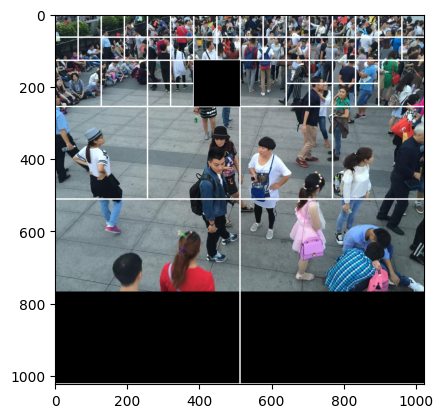

In [12]:
# 创建一个空白图像
result = np.zeros((max_size[0], max_size[1], 3), dtype=np.uint8)

for cropped_image in cropped_images:
    image = inverse_transform(cropped_image.image).cpu().numpy().transpose(1, 2, 0)
    image = (image * 255).astype(np.uint8)
    image = cv2.resize(image, (cropped_image.size[1], cropped_image.size[0]))

    border_size = 2
    
    # 将图片向内缩小2像素
    image = image[border_size:-border_size, border_size:-border_size]

    # 添加边框
    image = cv2.copyMakeBorder(image, border_size, border_size, border_size, border_size, cv2.BORDER_CONSTANT, value=(255, 255, 255))

    result[cropped_image.position[0]:cropped_image.position[0] + cropped_image.size[0],
           cropped_image.position[1]:cropped_image.position[1] + cropped_image.size[1]] = image
    
plt.imshow(result)
plt.show()